In [ ]:

import ssl
import os
import certifi

# Fix SSL certificate verification errors
ssl._create_default_https_context = ssl._create_unverified_context
os.environ['CURL_CA_BUNDLE'] = ''
os.environ['REQUESTS_CA_BUNDLE'] = ''

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from PIL import Image

/Users/prashannagc/Documents/neural network/multimodal_sentiment_analysis/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_csv("../data/amazon_fashion_reviews.csv")

# Map ratings to sentiment classes
def map_sentiment(rating):
    if rating <= 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df['sentiment'] = df['reviews.rating'].apply(map_sentiment)

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['sentiment'])
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['sentiment'])


In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_LEN = 128  # truncate/pad to 128 tokens

def tokenize_text(text):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encoding['input_ids'].squeeze(), encoding['attention_mask'].squeeze()


In [ ]:

image_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [20]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from io import BytesIO
import requests

class MultimodalDataset(Dataset):
    def __init__(self, df, transform=None, tokenizer=None, max_length=128):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # ----- Text -----
        text = str(row['reviews.text'])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze(0)  # remove batch dim
        attention_mask = encoding['attention_mask'].squeeze(0)

        # ----- Image -----
        img = None
        url = row['reviews.sourceURLs']
        if isinstance(url, str) and url.strip() != "":
            try:
                response = requests.get(url, timeout=5)
                img = Image.open(BytesIO(response.content)).convert("RGB")
                if self.transform:
                    img = self.transform(img)
            except:
                img = torch.zeros(3, 224, 224)  # fallback blank image
        else:
            img = torch.zeros(3, 224, 224)

     
        label = torch.tensor(row['sentiment'], dtype=torch.long)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'image': img,
            'label': label
        }


In [6]:
train_dataset = MultimodalDataset(train_df, transform=image_transforms, tokenizer=tokenizer)
val_dataset   = MultimodalDataset(val_df, transform=image_transforms, tokenizer=tokenizer)
test_dataset  = MultimodalDataset(test_df, transform=image_transforms, tokenizer=tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:

class MultimodalSentimentModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        # Text Model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.text_fc = nn.Linear(768, 256)

        # Image Model
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 256)

        # Fusion
        self.fc1 = nn.Linear(256+256, 128)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(128, num_classes)

    def forward(self, input_ids, attention_mask, images):
        # Text forward
        text_emb = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        text_feat = self.text_fc(text_emb)

        # Image forward
        img_feat = self.resnet(images)

        # Concatenate
        combined = torch.cat((text_feat, img_feat), dim=1)
        x = self.fc1(combined)
        x = self.dropout(x)
        out = self.out(x)
        return out


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalSentimentModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

EPOCHS = 3  


/Users/prashannagc/Documents/neural network/multimodal_sentiment_analysis/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/prashannagc/Documents/neural network/multimodal_sentiment_analysis/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct = 0, 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = correct / len(train_dataset)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_loss_list.append(val_loss/len(val_loader))
    val_acc_list.append(val_correct/len(val_dataset))

    print(f"Epoch {epoch+1}/{EPOCHS}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | "
          f"Val Loss={val_loss_list[-1]:.4f}, Val Acc={val_acc_list[-1]:.4f}")


Epoch 1/3: Train Loss=0.4814, Train Acc=0.8675 | Val Loss=1.5684, Val Acc=0.8750
Epoch 2/3: Train Loss=0.3631, Train Acc=0.8818 | Val Loss=1.1739, Val Acc=0.8750
Epoch 3/3: Train Loss=0.2460, Train Acc=0.9060 | Val Loss=0.4021, Val Acc=0.9000


In [17]:

# torch.save(model.state_dict(), "../models/multimodal_model.pth")


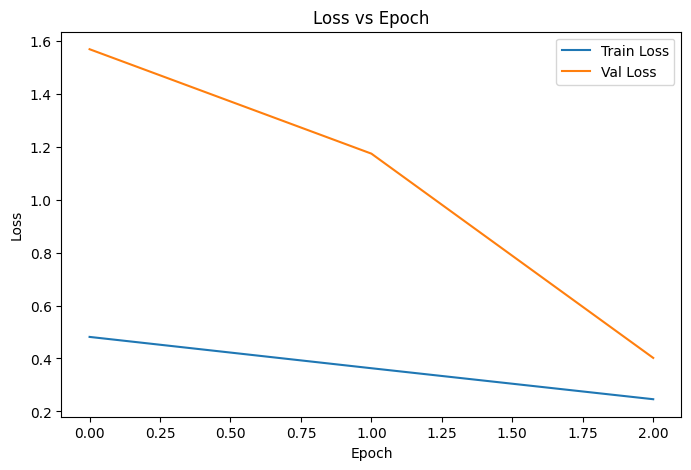

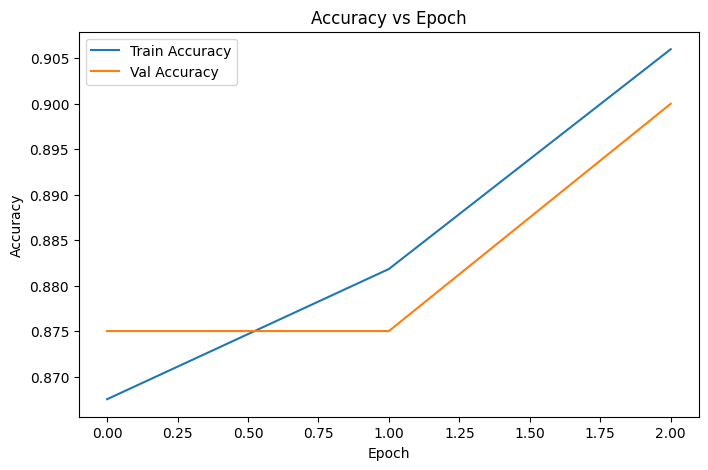

In [11]:

plt.figure(figsize=(8,5))
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Val Accuracy")
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [22]:
batch = next(iter(test_loader))
print(type(batch))
print(len(batch))
print([type(x) for x in batch])


<class 'dict'>
4
[<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]


In [31]:
# model.eval()
# y_true, y_pred = [], []

# with torch.no_grad():
#     for batch in test_loader:

#         # -------- SAFE UNPACK --------
#         texts = batch[0]          # main review text
#         image_urls = batch[-2]    # image/source URL
#         labels = batch[-1]        # label (always last)

#         # -------- TEXT TOKENIZATION --------
#         encoding = tokenizer(
#             list(texts),
#             padding=True,
#             truncation=True,
#             max_length=128,
#             return_tensors="pt"
#         )

#         input_ids = encoding["input_ids"].to(device)
#         attention_mask = encoding["attention_mask"].to(device)

#         # -------- IMAGE PROCESSING --------
#         images = []
#         for url in image_urls:
#             try:
#                 response = requests.get(url, timeout=5)
#                 img = Image.open(BytesIO(response.content)).convert("RGB")
#                 img = image_transforms(img)
#             except:
#                 img = torch.zeros(3, 224, 224)
#             images.append(img)

#         images = torch.stack(images).to(device)
#         labels = labels.to(device)

#         # -------- MODEL PREDICTION --------
#         outputs = model(input_ids, attention_mask, images)
#         preds = outputs.argmax(1)

#         y_true.extend(labels.cpu().numpy())
#         y_pred.extend(preds.cpu().numpy())


In [30]:
# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(
#     cm,
#     display_labels=["Negative", "Neutral", "Positive"]
# )
# disp.plot(cmap="Blues")
# plt.title("Confusion Matrix – Multimodal Sentiment Model")
# plt.show()


In [32]:

for i in range(5):
    print("Review Text:", test_df.iloc[i]['reviews.text'])
    print("True Sentiment:", test_df.iloc[i]['sentiment'])
    # print("Predicted Sentiment:", y_pred[i])
    print("-"*60)


Review Text: Nice price for a gift idea at the time. Small compact version of Alexa.
True Sentiment: 2
------------------------------------------------------------
Review Text: If you read my Fire TV review you know that I am tough on Amazon when it comes to their own items. It needs to deliver quality for the price point to earn stars from me. Please take the time to read my entire review and feel free to ask questions. I will do my best to respond to them as I can and update the review to reflect those answers and other things I discover along the way.First my background. I own many Amazon Kindles (bw, Fire gen2, Fire gen3) as well as Apple Ipad (gen 4), Samsung Note 3 and have an LG G2 smartphone (had a Samsung S4 before that), notebooks, chromebooks, etc. I have also used many other products including the Fire HDX line. I have a solid computer background as well but honestly I am more of a casual user when it comes to tablets like this one.Amazon has changed many things over the li

In [13]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask, images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')


print("Model Performance on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")


Model Performance on Test Set:
Accuracy : 0.9000
Precision: 0.8990
Recall   : 0.9000
F1-score : 0.8761
